#### Model Controls

In [115]:
RUN_GRID_SEARCH_CV = False

#### Base Library Imports

In [116]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
%matplotlib inline



#### Load Data

In [117]:
df = pd.read_csv('../../../../../../data/cardio_train.csv', delimiter=';')
# set id as index
df.set_index("id", inplace=True)
# copy original data
df_clean = df.copy(deep=True)
# drop duplicates
df_clean.drop_duplicates(inplace=True)



#### Transformations

In [118]:
# %%time

# Convert age into years
df_clean['age'] = (df_clean['age'] / 365).round().astype('int')

# re-encode gender to 1 (male) and 0 (female)
df_clean['gender'] = np.where((df_clean.gender == 2), 1, 0)

# compute the body mass index based on weight and height
df_clean['bmi'] = df_clean['weight'] / (df_clean['height']/100)**2

# create a BMI group
df_clean['bmiGrp'] = np.where((df_clean.bmi < 18.5), 1, 0)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 18.5) & (df_clean.bmi < 25), 2, df_clean.bmiGrp)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 25) & (df_clean.bmi < 30), 3, df_clean.bmiGrp)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 30), 4, df_clean.bmiGrp)

# bin blood pressure groups based on the api hi/ lo variables
df_clean['bp'] = np.where((df_clean.ap_hi < 120) & (df_clean.ap_lo < 80), 1, 0)
df_clean['bp'] = np.where((df_clean.ap_hi >= 120) & (df_clean.ap_hi < 130) & (df_clean.ap_lo < 80), 2, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi >= 130) & (df_clean.ap_hi < 140) | ((df_clean.ap_lo >= 80) & (df_clean.ap_lo < 90)), 3, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi >= 140) | (df_clean.ap_lo >= 90), 4, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi > 180) | (df_clean.ap_lo > 120), 5, df_clean.bp)



In [119]:
# Full Model
# X_cols = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# New Feature Model
X_cols = ['age', 'gender', 'bmiGrp', 'bp', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Store feature matrix 
X = df_clean[X_cols] #.to_numpy()
# Store response vector
y = df_clean['cardio'] #.to_numpy()



# Create Models (50 points)

Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 



In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC



## Logistic Regression

Model consisting of all original and new features with standardized values.


In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

rs = RobustScaler()
X_train_std = rs.fit_transform(X_train)
X_test_std = rs.transform(X_test)

# sc = StandardScaler()
# X_train_std = sc.fit_transform(X_train)
# X_test_std = sc.transform(X_test)

# si = SimpleImputer(strategy="median")
# X_train_std = si.fit_transform(X_train_std)
# X_test_std = si.transform(X_test_std)

logreg = LogisticRegression(n_jobs=-1, random_state=1)
logreg.fit(X_train_std, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=1,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

# Interpret Feature Importance (30)

Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

In [122]:
# sort these attributes and spit them out
zip_vars = zip(logreg.coef_.T, X.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', round(coef[0], 3)) # now print them out

active has weight of -0.201
alco has weight of -0.2
smoke has weight of -0.109
gluc has weight of -0.091
gender has weight of 0.031
bmiGrp has weight of 0.468
cholesterol has weight of 0.535
age has weight of 0.539
bp has weight of 0.79


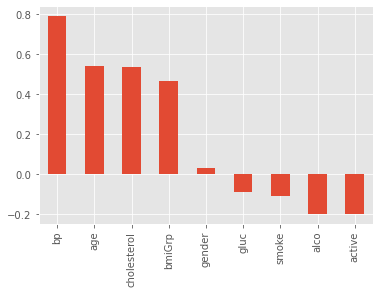

In [123]:
# now let's make a pandas Series with the names and values, and plot them

from collections import OrderedDict

plt.style.use('ggplot')

coef_dict = {}

for coef, feat in zip(logreg.coef_[0,:], X.columns):
    coef_dict[feat] = coef

coef_dict = OrderedDict({k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])})
  
# weights = pd.Series(logreg.coef_[0],index=X.columns)
weights = pd.Series(coef_dict).sort_values(ascending=False)
weights.plot(kind='bar')
plt.show()


In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

X_train = pd.get_dummies(X_train, columns=['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'])
X_test = pd.get_dummies(X_test, columns=['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'])

rs = RobustScaler()
X_train_std = rs.fit_transform(X_train)
X_test_std = rs.transform(X_test)

# use get dummies instead
# ohe = OneHotEncoder()
# X_train_std = ohe.fit_transform(X_train_std)
# X_test_std = ohe.transform(X_test_std)

logreg = LogisticRegression(n_jobs=-1, random_state=1)
logreg.fit(X_train_std, y_train)




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=1,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [125]:
# sort these attributes and spit them out
zip_vars = zip(logreg.coef_.T, X_train.columns) # combine attributes
zip_vars = zip_vars
for coef, name in zip_vars:
    print(name, 'has weight of', round(coef[0], 3)) # now print them out

    

age has weight of 0.539
bmiGrp has weight of 0.462
bp has weight of 0.788
gender_0 has weight of -0.015
gender_1 has weight of 0.015
cholesterol_1 has weight of -0.535
cholesterol_2 has weight of -0.057
cholesterol_3 has weight of 0.592
gluc_1 has weight of 0.067
gluc_2 has weight of 0.15
gluc_3 has weight of -0.217
smoke_0 has weight of 0.055
smoke_1 has weight of -0.055
alco_0 has weight of 0.102
alco_1 has weight of -0.102
active_0 has weight of 0.1
active_1 has weight of -0.1


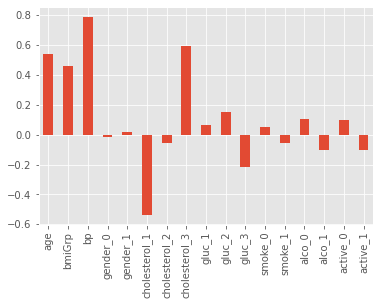

In [126]:

weights = pd.Series(logreg.coef_[0], X_train.columns)
weights.plot(kind='bar')
plt.show()



In [127]:
y_pred = logreg.predict(X_test_std)

In [128]:
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.71      0.70      0.70      7001
           1       0.70      0.72      0.71      6995

    accuracy                           0.71     13996
   macro avg       0.71      0.71      0.71     13996
weighted avg       0.71      0.71      0.71     13996



In [129]:
scores = cross_val_score(logreg, X_train_std, y_train,
                         scoring="roc_auc", cv=3)

def display_scores(scores):
    print("Scores:", scores.round(3))
    print("Mean:", scores.mean().round(3))
    print("Standard deviation:", scores.std().round(3))

display_scores(scores)

Scores: [0.771 0.767 0.77 ]
Mean: 0.769
Standard deviation: 0.002


In [130]:
# if MODEL_TYPE == "Full":
#     # Full Model
#     num_attribs = ["age", "height", "weight", "ap_hi", "ap_lo"]
#     cat_attribs = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]
# else:
# New Features
num_attribs = ["age", "bmiGrp", "bp"]
cat_attribs = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]



In [131]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report


num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbs_scaler', RobustScaler()),
        # ('std_scaler', StandardScaler()),
    ])


In [132]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(drop="first"), cat_attribs),
    ])

X_prepared = full_pipeline.fit_transform(X)

# Model Advantages (10)

Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.


In [133]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, stratify=y, test_size=0.2, random_state=1)


In [134]:
logreg = LogisticRegression(n_jobs=-1, C=2, random_state=1)
logreg.fit(X_train, y_train)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=1,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [135]:
y_pred = logreg.predict(X_test)


In [136]:
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.71      0.70      0.70      7001
           1       0.70      0.72      0.71      6995

    accuracy                           0.71     13996
   macro avg       0.71      0.71      0.71     13996
weighted avg       0.71      0.71      0.71     13996



In [137]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[4876 2125]
 [1969 5026]]


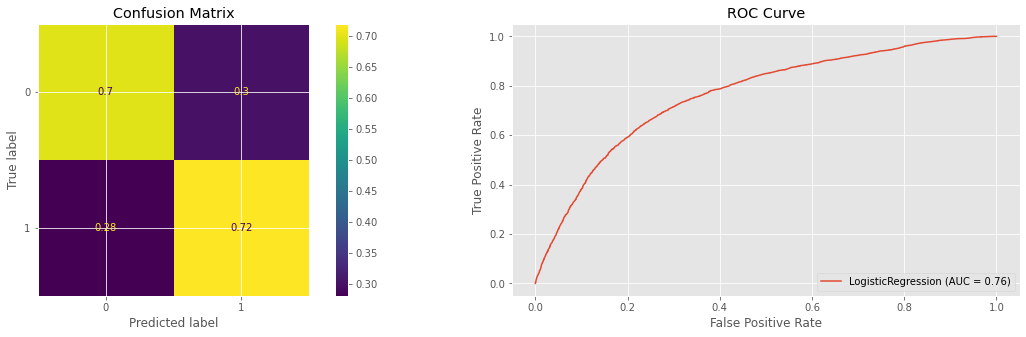

In [138]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

fig = plt.figure(1, figsize=(20, 5))

chart_1 = fig.add_subplot(121)
chart_2 = fig.add_subplot(122)

plot_confusion_matrix(logreg, X_test, y_test, normalize='true', ax=chart_1)
chart_1.set_title('Confusion Matrix')

plot_roc_curve(logreg, X_test, y_test, ax=chart_2)
chart_2.set_title('ROC Curve')

plt.show()

In [139]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
# from sklearn.svm import LinearSVC
# from sklearn.svm import SVC

model_params = {
    "sgd": {
        "model": SGDClassifier(),
        "params": {
            "alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1],
            "class_weight": ["balanced", None]
        }
    },
    "logistic_regression": {
        "model": LogisticRegression(),
        "params": {
            "C": [1, 2, 5, 10, 15, 20]
        }
    },
    "linear_svc": {
        "model": LinearSVC(),
        "params": {
            "C": [1, 2, 5, 10, 15, 20], 
            "class_weight": ["balanced", None]
        }
    },
    # "svc": {
    #     "model": SVC(),
    #     "params": {
    #         "C": [1, 10, 100, 1000],
    #         "kernel": ["rbf"],
    #         "gamma": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    #     }
    # },
}



In [140]:
if (RUN_GRID_SEARCH_CV):

    from sklearn.model_selection import GridSearchCV

    scores = []

    for model_name, mp in model_params.items():
        clf = GridSearchCV(estimator = mp["model"], param_grid=mp["params"], cv=10, scoring="roc_auc", n_jobs=-1)
        clf.fit(X_train, y_train)
        scores.append({"model": model_name,
        "best_score": clf.best_score_, # Mean cross-validated score of the best_estimator
        "best_params": clf.best_params_
        })

    df_grid_search_scores = pd.DataFrame(scores, columns=["model", "best_score", "best_params"])
    print(df_grid_search_scores)


## SGDClassifier

In [141]:

svm_sgd = SGDClassifier(alpha=0.001, class_weight="balanced", n_jobs=-1, random_state=1) # get object

In [142]:
svm_sgd.fit(X_train, y_train)  # train object

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [143]:
y_pred = svm_sgd.predict(X_test)

In [144]:
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.71      0.70      0.70      7001
           1       0.70      0.71      0.71      6995

    accuracy                           0.71     13996
   macro avg       0.71      0.71      0.71     13996
weighted avg       0.71      0.71      0.71     13996



## LinearSVC

In [145]:

svm_lin = LinearSVC(C=15, class_weight=None) # get object
svm_lin.fit(X_train, y_train)  # train object


LinearSVC(C=15, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [146]:
y_pred = svm_lin.predict(X_test)

In [147]:
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.72      0.69      0.70      7001
           1       0.70      0.73      0.71      6995

    accuracy                           0.71     13996
   macro avg       0.71      0.71      0.71     13996
weighted avg       0.71      0.71      0.71     13996



## SVC

In [148]:

svm_best = SVC(kernel='rbf', C=1, gamma=0.1, class_weight="balanced", random_state=1) # get object
svm_best = SVC() # get object


In [149]:
svm_best.fit(X_train, y_train)  # train object

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [150]:
y_pred = svm_best.predict(X_test)

In [151]:
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.70      0.79      0.74      7001
           1       0.76      0.66      0.71      6995

    accuracy                           0.72     13996
   macro avg       0.73      0.72      0.72     13996
weighted avg       0.73      0.72      0.72     13996



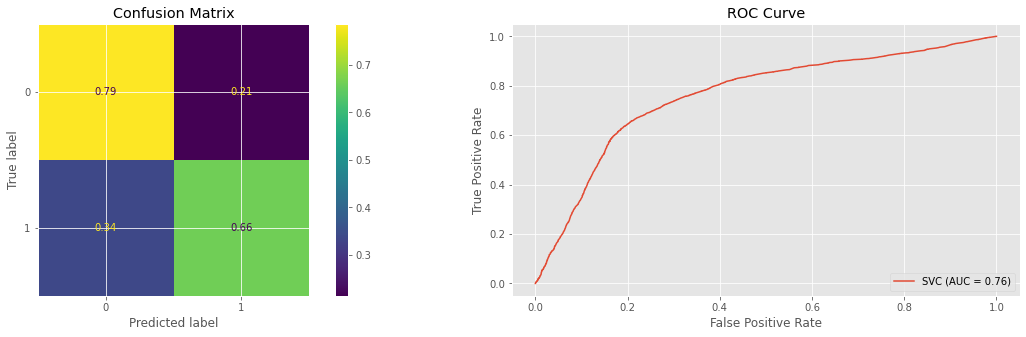

In [152]:
fig = plt.figure(1, figsize=(20, 5))

chart_1 = fig.add_subplot(121)
chart_2 = fig.add_subplot(122)

plot_confusion_matrix(svm_best, X_test, y_test, normalize='true', ax=chart_1)
chart_1.set_title('Confusion Matrix')

plot_roc_curve(svm_best, X_test, y_test, ax=chart_2)
chart_2.set_title('ROC Curve')

plt.show()

# Interpret Support Vectors (10)

Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.